In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from datetime import datetime, timedelta

pd.options.mode.chained_assignment = None

In [3]:
# read in LLM-generated data
data = pd.read_csv("../data/sample_user_running_app_data.csv")

### 1. Segment on Demographics

##### Distribution of Users - Age

In [4]:
# Group by age
bins = [18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 65]
runnersAgeGroups = data.groupby(pd.cut(data['age'], bins)).count()[['user_id']].rename(columns={'user_id': 'numUsers'})
runnersAgeGroups


C:\Users\cliff\AppData\Local\Temp\ipykernel_12164\732408143.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runnersAgeGroups = data.groupby(pd.cut(data['age'], bins)).count()[['user_id']].rename(columns={'user_id': 'numUsers'})


,numUsers
age,
"(18, 22]",23847
"(22, 26]",24712
"(26, 30]",22740
"(30, 34]",22257
"(34, 38]",23814
"(38, 42]",21768
"(42, 46]",22286
"(46, 50]",21491
"(50, 54]",22337


##### Distribution of Users - Annual Income

In [5]:
# Group by income 
bins = [0, 30000, 50000, 70000, 90000, 120000, 150000]

runnersIncomeGroups = data.groupby(pd.cut(data['annual_income'], bins)).count()[['user_id']].rename(columns={'user_id': 'numUsers'})
runnersIncomeGroups


C:\Users\cliff\AppData\Local\Temp\ipykernel_12164\1760945037.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runnersIncomeGroups = data.groupby(pd.cut(data['annual_income'], bins)).count()[['user_id']].rename(columns={'user_id': 'numUsers'})


,numUsers
annual_income,
"(0, 30000]",20357
"(30000, 50000]",40458
"(50000, 70000]",41661
"(70000, 90000]",42466
"(90000, 120000]",62173
"(120000, 150000]",61278


##### Distribution of Users - Geography

In [6]:
# Group by geographical region 
runnersGeoLocGroups = data.groupby('geographic_location').count()[['user_id']].rename(columns={'user_id': 'numUsers'})
runnersGeoLocGroups

,numUsers
geographic_location,
rural,89982
suburban,90065
urban,88346


##### Distribution of Users - Sex

In [7]:
# Group by sex
runnersGenderGroups = data.groupby('gender').count()[['user_id']].rename(columns={'user_id': 'numUsers'})
runnersGenderGroups

,numUsers
gender,
female,134110
male,134283


### Finding 1: 

##### Established that gender, geographic location, and age are quite evenly split and do not provide discriminatory power. It suggests running is quite an accessible sport. Now we investigate time-based factors to try and find things that have changed recently to induce this spike in popularity.

### 2. Calculate North Star Metrics 
##### Growth - New runners per month 

##### Engagement - Average hours run per two weeks 

##### Growth - Number of active users (activity logged 6 / 12 months in a year)

##### NSM 1: New Runners per Month

In [8]:
# Group by member_since_date: month/year
memSinceSegment = data 
memSinceSegment['member_since_year'] = pd.DatetimeIndex(data['member_since_date']).year
memSinceSegment['member_since_month'] = pd.DatetimeIndex(data['member_since_date']).month

runnersStartDateGroups = memSinceSegment.groupby(['member_since_year', 'member_since_month']).count()[['user_id']].rename(columns={'user_id': 'numUsers'})

In [9]:
runnersStartDateGroups.head(5)

numUsers
member_since_year member_since_month          
2014              7                        299
                  8                       2649
                  9                       2572
                  10                      2448
                  11                      2149

### Finding 2 a)

##### Many of the largest sign up groups have been around the time of the pandemic

In [10]:
# Format data for plotting timeseries data
runStartDatePlot = runnersStartDateGroups.reset_index()
runStartDatePlot['month_year'] = runStartDatePlot['member_since_month'].astype('str') + ' / ' + runStartDatePlot['member_since_year'].astype('str')

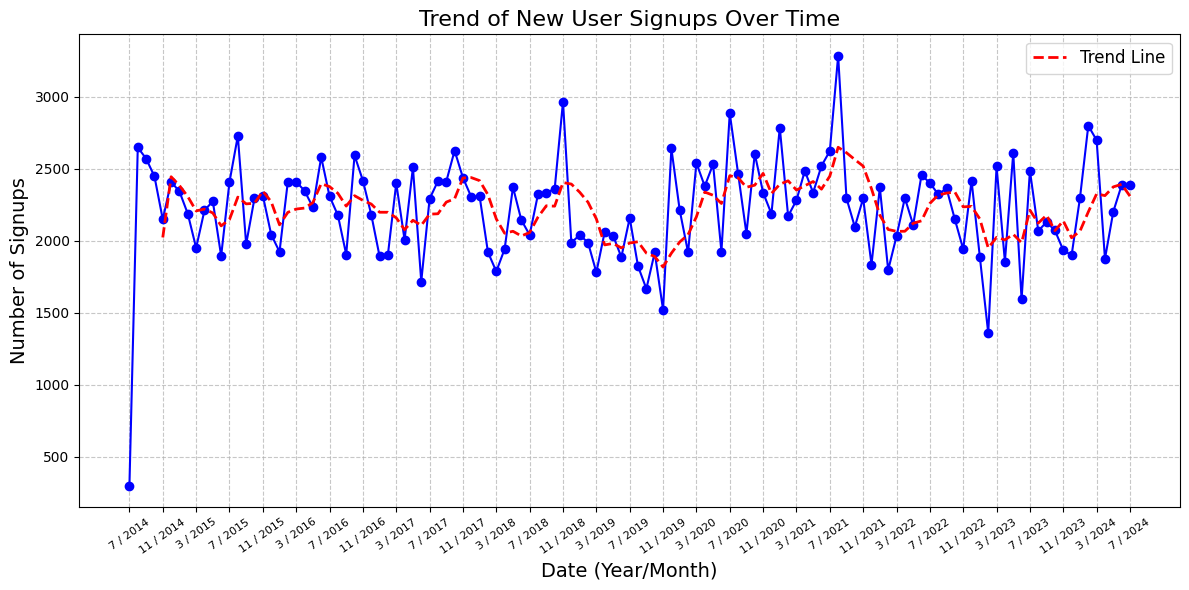

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(runStartDatePlot['month_year'], runStartDatePlot['numUsers'], marker='o', linestyle='-', color='b')

# Customize the x-axis to show fewer ticks (sparse enough to be accessible)
plt.xticks(runStartDatePlot['month_year'][::4], fontsize=8, rotation=35)

# Customize other elements for clarity
plt.title('Trend of New User Signups Over Time', fontsize=16)
plt.xlabel('Date (Year/Month)', fontsize=14)
plt.ylabel('Number of Signups', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the trend with a smoother line (optional)
plt.plot(runStartDatePlot['month_year'], runStartDatePlot['numUsers'].rolling(window=5).mean(), color='red', linestyle='--', linewidth=2, label='Trend Line')
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### Finding 2 b) 

##### General rise and fall of signups, spiking towards the end of the year. Could be in-line with new years resolutions. Large period of constant growth through pandemic. Decline starting 2022. Growing again recently.

### NSM 2: Average hours run per two weeks 

In [12]:
# Avg minutes run per Two Weeks

runHoursTwoWeeks = data
runHoursTwoWeeks['run_date'] = pd.to_datetime(runHoursTwoWeeks['run_date'])
runHoursTwoWeeks['month'] = runHoursTwoWeeks['run_date'].dt.month
runHoursTwoWeeks['year'] = runHoursTwoWeeks['run_date'].dt.year
runHoursTwoWeeks['isFirstHalf'] = runHoursTwoWeeks['run_date'].dt.day <= 15

runTwoWeekGroup = runHoursTwoWeeks[['user_id', 'year', 'month', 'isFirstHalf', 'run_duration_min']].groupby(['user_id', 'year', 'month', 'isFirstHalf']).sum()[['run_duration_min']].rename(columns={'run_duration_min': 'minRunPerTwoWeeks'}).reset_index()
runTwoWeekGroup.sort_values(by=['user_id', 'year', 'month', 'isFirstHalf'], ascending=[True, True, True, False])

annual_runTwoWeekMetric = runTwoWeekGroup[['year', 'minRunPerTwoWeeks']].groupby('year').mean().rename(columns={'minRunPerTwoWeeks': 'annAvgMinPerTwoWeeks'}).reset_index()
print(f"NTM: Annual Avg Min Run Per Two Weeks: \n{annual_runTwoWeekMetric}")

annual_runTwoWeekMetric


NTM: Annual Avg Min Run Per Two Weeks: 
   year  annAvgMinPerTwoWeeks
0  2022             86.644058
1  2023             86.517474
2  2024             86.456337


,year,annAvgMinPerTwoWeeks
0,2022,86.644058
1,2023,86.517474
2,2024,86.456337


### Finding 2 c)
##### Avg Min Run per Two weeks stay pretty consistent from 2021 - 2024. Worth segmenting then recalculating to see if there are pockets that have seen a rise in avg min run per two weeks

### NSM 3: Number of Active Users

In [13]:
# Number of users with activity logged 6 / 12 months in a year
halfYearActive = data
halfYearActive['run_date'] = pd.to_datetime(halfYearActive['run_date'])
halfYearActive['month'] = halfYearActive['run_date'].dt.month
halfYearActive['year'] = halfYearActive['run_date'].dt.year

# group by: user, year, month - then count
halfYearGroup = halfYearActive[['user_id', 'year', 'month', 'run_date']].groupby(['user_id', 'year', 'month']).count().reset_index()
halfYearGroup
halfYearFinGroup = halfYearGroup.groupby(['user_id', 'year']).count().reset_index()[['user_id', 'year', 'run_date']].rename(columns={'run_date': 'monthsRunPerYear'})
halfYearFinGroup.sort_values(by=['user_id', 'year'], ascending=[True, True])

halfYearTmp = {'year': [], 'pctRunHalfYear': []}
for y in [2022, 2023, 2024]:
    tmpYearGroup = halfYearFinGroup[halfYearFinGroup['year'] == y]
    halfYearTmp['year'].append(y)
    halfYearTmp['pctRunHalfYear'].append(len((tmpYearGroup[tmpYearGroup['monthsRunPerYear'] >= 6])) / len(tmpYearGroup))
halfYearRes = pd.DataFrame(halfYearTmp)
halfYearRes

,year,pctRunHalfYear
0,2022,0.656282
1,2023,0.656338
2,2024,0.198352



### Finding 2 d)

##### The percentage of active runners remained static from 2022 - 2023, while 2024 is significantly lower, likely due to incomplete annual data (currently only August)

In [14]:
################## Explore reasons ##################

# Does social media have an influence? - to research

# Increase in health and fitness awareness? - to research

# Rise in technology and apps? - done

# Rise in health/wellness brands? - done

### 3 Rise of Running/Athleisure Brands

##### Given the only discriminating factor that can be found in the previous analysis is income, we will investigate the rise in health/wellness brands. We have in general seen a rise in popularity in brands such as Lululemon, Alo, Nike, and Hoka. These brands sell clothing that can get quite pricey as brands like Alo and Lulu target the upper-middle class.

In [15]:
# Data Collection 
brand_data = {
    'quarter': ['q1', 'q2', 'q3', 'q4'] * 7, 
    'year': [2018, 2018, 2018, 2018, 
             2019, 2019, 2019, 2019, 
             2020, 2020, 2020, 2020, 
             2021, 2021, 2021, 2021, 
             2022, 2022, 2022, 2022, 
             2023, 2023, 2023, 2023, 
             2024, 2024, 2024, 2024], 
    'lulu_revenue_mil': [649.7, 723.5, 747.7, 1200.0, 
                         782.3, 883.4, 916.1, 1400.0, 
                         652.0, 902.9, 1100.0, 1700.0,  # end is 2020
                         1200.0, 1500.0, 1500.0, 2100.0, 
                         1600.0, 1900.0, 1900.0, 2800.0,  
                         2000.7, 2209.2, 2204.2, 3205.1, # end is 2023
                         2208.9, None, None, None], 
    # 'lulu_gross_profit_mil': [344.7, 396.2, 406.8, 668.6, 
    #                           421.7, 485.8, 505.0, 810.8, 
    #                           334.4, 489.5, 627.4, 1000.0,  # end is 2020
    #                           700.3, 842.7, 829.4, 1200.0, 870.4, 
    #                           1100.0, 1000.0, 1527.6, 1150.8, 
    #                           1298.5, 1256.6, 1903.4, # end is 2023
    #                           1275.1, None, None, None],  
    'hoka_revenue_mil': [50.4, 47.0, 52.1, 56.9,
                     67.1, 79.5, 78.1, 93.1,
                     101.9, 109.0, 143.1, 141.6,
                     177.5, 213.1, 210.4, 184.6,
                     283.5, 333.0, 333.0, 352.1,
                     397.7, 420.5, 424.0, 429.3,
                     553.8, None, None, None], 
    # 'hoka_gross_profit_mil': [], 
    'on_revenue_mil': [None, None, None, None,
                       None, None, None, None, 
                       150.3, 162.7, 179.2, 201.2, 
                       202.9, 256.3, 264.3, 289.1, 
                       271.5, 335.9, 377.8, 422.5,
                       483.9, 511.7, 553.4, 514.9,
                       585.3, None, None, None], 
    # 'on_gross_profit_mil': []
    }

stock_prices = {
    'dates': ['1-2022', '4-2022', '7-2022', '10-2022', '1-2023', '4-2023', '7-2023', '10-2023', '1-2024', '4-2024'],
    'lululemon': [355.1, 367.4, 293.4, 298.2, 329.2, 364.3, 380.4, 367.2, 491.1, 356.4],
    'decker': [338.1, 263.7, 270.5, 334.9, 399.1, 446.4, 527.2, 597.1, 652.3, 833.5],
    'on_holding': [26.4, 24.8, 21.8, 17.59, 23.2, 32.5, 36.0, 25.7, 25.6, 42.54]
}

### 3.1 Stock Prices of Popular Brands 
##### Plotting stock prices of 3 companies: Lululemon, Decker (Hoka), and on

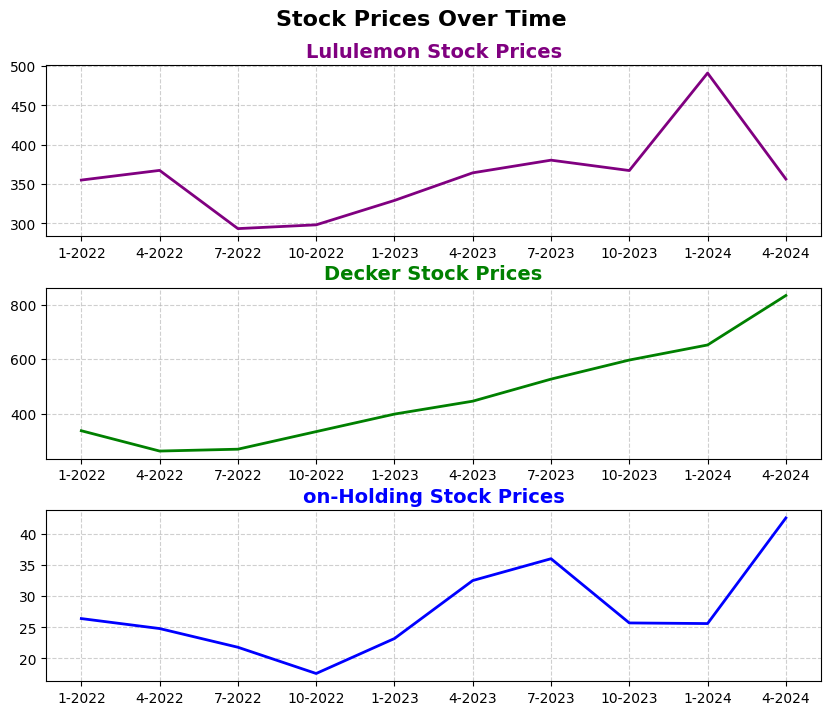

In [16]:
# plotting stock prices
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.3)  # Adjusted spacing between plots
fig = plt.figure(figsize=(10, 8))  # Larger figure size

# First subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(stock_prices['dates'], stock_prices['lululemon'], color='purple', linestyle='-', linewidth=2)
ax1.set_title('Lululemon Stock Prices', fontsize=14, fontweight='bold', color='purple')
ax1.grid(True, linestyle='--', alpha=0.6)

# Second subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(stock_prices['dates'], stock_prices['decker'], color='green', linestyle='-', linewidth=2)
ax2.set_title('Decker Stock Prices', fontsize=14, fontweight='bold', color='green')
ax2.grid(True, linestyle='--', alpha=0.6)

# Third subplot
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(stock_prices['dates'], stock_prices['on_holding'], color='blue', linestyle='-', linewidth=2)
ax3.set_title('on-Holding Stock Prices', fontsize=14, fontweight='bold', color='blue')
ax3.grid(True, linestyle='--', alpha=0.6)

# Overall figure title
fig.suptitle('Stock Prices Over Time', fontsize=16, fontweight='bold', color='black', y=0.95)

# Display the plot
plt.show()

### Finding 3.1

##### Stock prices of popular athleisure companies, and more specifically leaders in the running-shoe space, saw steep rises in stock prices from mid-late 2022 onwards. Stock prices often correlate strongly with consumer sentiment

### 3.2 Financials of Popular Brands

In [17]:
# Finding YoY revenue increase
yoyRev = pd.DataFrame(brand_data)
yoyRevAvg = yoyRev[['year', 'lulu_revenue_mil', 'hoka_revenue_mil', 'on_revenue_mil']].groupby('year').mean()
yoyRevAvg.columns = ['lulu_avg_annual_rev', 'hoka_rev_annual_rev', 'on_rev_annual_rev']
yoyRevAvg.reset_index()
yoyRevAvg['yoy_lulu_pct_inc'] = ((yoyRevAvg['lulu_avg_annual_rev'] - yoyRevAvg['lulu_avg_annual_rev'].shift()) / ((yoyRevAvg['lulu_avg_annual_rev'] + yoyRevAvg['lulu_avg_annual_rev'].shift()) / 2)) * 100
yoyRevAvg['yoy_hoka_pct_inc'] = ((yoyRevAvg['hoka_rev_annual_rev'] - yoyRevAvg['hoka_rev_annual_rev'].shift()) / ((yoyRevAvg['hoka_rev_annual_rev'] + yoyRevAvg['hoka_rev_annual_rev'].shift()) / 2)) * 100
yoyRevAvg['yoy_on_pct_inc'] = ((yoyRevAvg['on_rev_annual_rev'] - yoyRevAvg['on_rev_annual_rev'].shift()) / ((yoyRevAvg['on_rev_annual_rev'] + yoyRevAvg['on_rev_annual_rev'].shift()) / 2)) * 100
yoyRevAvg


,lulu_avg_annual_rev,hoka_rev_annual_rev,on_rev_annual_rev,yoy_lulu_pct_inc,yoy_hoka_pct_inc,yoy_on_pct_inc
year,,,,,,
2018,830.225,51.600,NaN,NaN,NaN,NaN
2019,995.450,79.450,NaN,18.100155,42.502862,NaN
2020,1088.725,123.900,173.350,8.950784,43.717728,NaN
2021,1575.000,196.400,253.150,36.510901,45.270059,37.420868
2022,2050.000,325.400,351.925,26.206897,49.444232,32.648845
2023,2404.800,417.875,515.975,15.928886,24.883119,37.803894
2024,2208.900,553.800,585.300,-8.492100,27.977462,12.589953


### Finding 3.2
##### Greatest increase in annual revenue from periods 2021 - 2023, which aligns with previous findings. Greatest jump in signups around 2020, momentum of 2020 signups carried forward. Since this apparel is upper-middle class targetting, would also align with greater population of higher income users. Could suggest a rise in upper-middle class users picking up running

## 4. Investigating age segments 18-35 and 36-50

### 4.1 New Runner Signups (18-35)

In [18]:
# Dive deeper into age segmentation, see when those members have signed up

ageGroup = data[data['age'] < 35]
ageGroup.drop(columns=['Unnamed: 0'], inplace=True)

ageGroup['member_since_year'] = pd.DatetimeIndex(ageGroup['member_since_date']).year
ageGroup['member_since_month'] = pd.DatetimeIndex(ageGroup['member_since_date']).month

ageGroupStartDate = ageGroup[['user_id', 'member_since_year', 'member_since_month']].groupby(['member_since_year', 'member_since_month']).count().rename(columns={'user_id': 'numUsers'}).reset_index()
ageGroupStartDate

,member_since_year,member_since_month,numUsers
0,2014,7,77
1,2014,8,1391
2,2014,9,900
3,2014,10,789
4,2014,11,770
...,...,...,...
116,2024,3,1073
117,2024,4,591
118,2024,5,751
119,2024,6,910


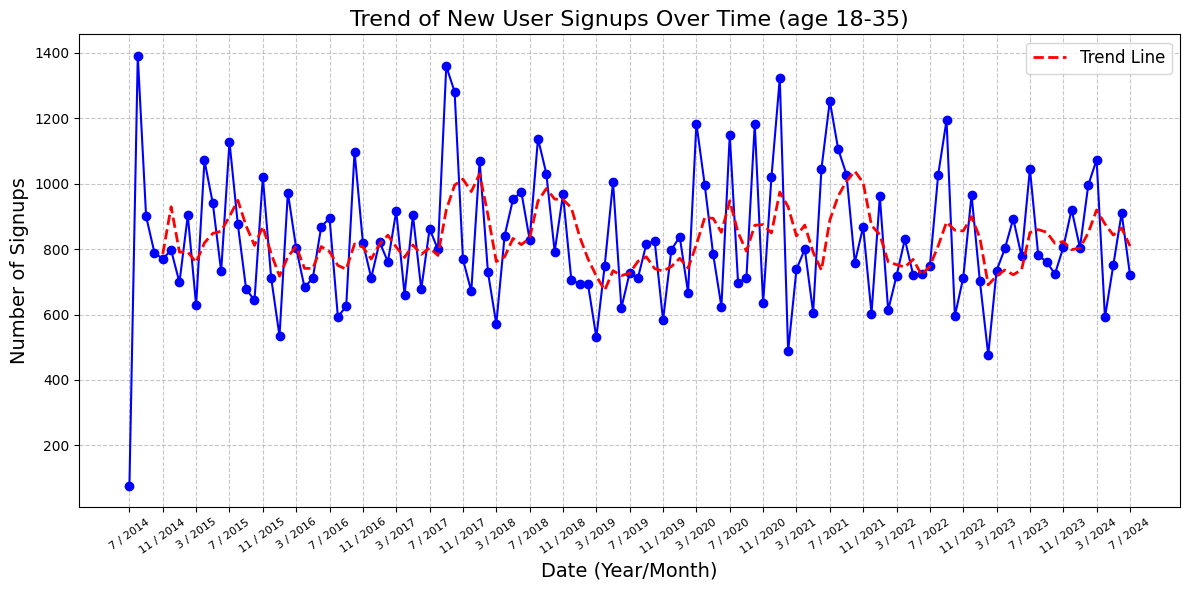

In [19]:
# Checking for ages 18-35

# Format dates into month-year
ageGroupStartDatePlot = ageGroupStartDate
ageGroupStartDatePlot['month_year'] = ageGroupStartDatePlot['member_since_month'].astype('str') + ' / ' + ageGroupStartDatePlot['member_since_year'].astype('str')

# Plot data
plt.figure(figsize=(12, 6))
plt.plot(ageGroupStartDatePlot['month_year'], ageGroupStartDatePlot['numUsers'], marker='o', linestyle='-', color='b')

# Customize the x-axis to show fewer ticks (sparse enough to be accessible)
plt.xticks(ageGroupStartDatePlot['month_year'][::4], fontsize=8, rotation=35)

# Customize other elements for clarity
plt.title('Trend of New User Signups Over Time (age 18-35)', fontsize=16)
plt.xlabel('Date (Year/Month)', fontsize=14)
plt.ylabel('Number of Signups', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the trend with a smoother line (optional)
plt.plot(ageGroupStartDatePlot['month_year'], ageGroupStartDatePlot['numUsers'].rolling(window=5).mean(), color='red', linestyle='--', linewidth=2, label='Trend Line')
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### 4.2 New Runner Signups (36-50)

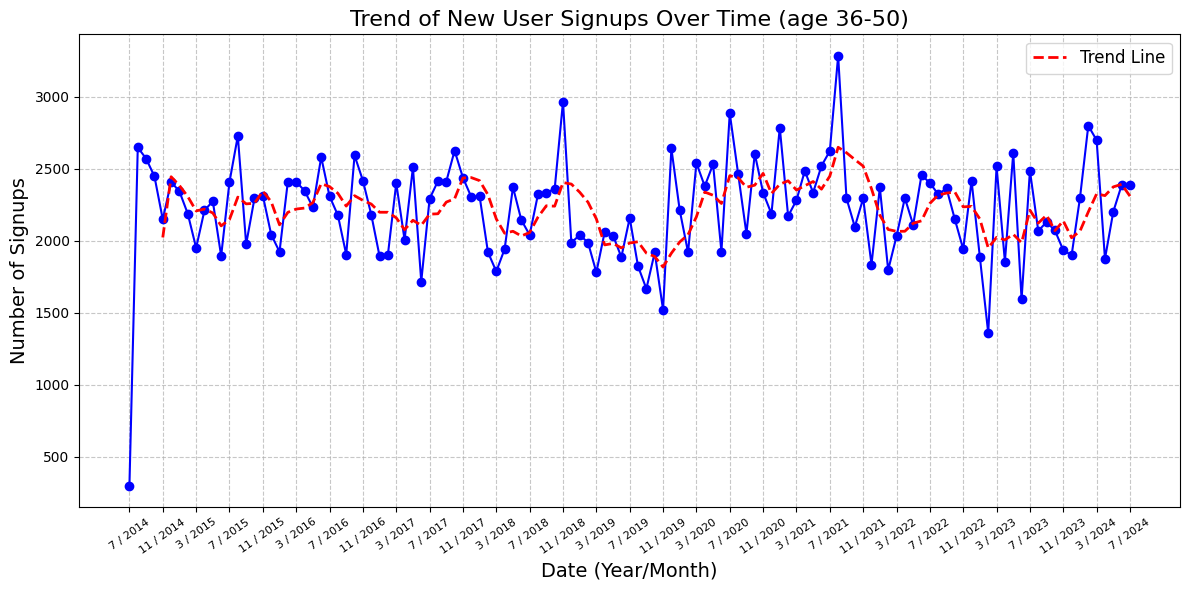

In [20]:
# Checking for ages 36-50

ageGroup3650 = data[(data['age'] > 35) & data['age'] <= 50]
ageGroup3650.drop(columns=['Unnamed: 0'], inplace=True)

ageGroup3650['member_since_year'] = pd.DatetimeIndex(ageGroup3650['member_since_date']).year
ageGroup3650['member_since_month'] = pd.DatetimeIndex(ageGroup3650['member_since_date']).month

ageGroupStartDate3650 = ageGroup3650[['user_id', 'member_since_year', 'member_since_month']].groupby(['member_since_year', 'member_since_month']).count().rename(columns={'user_id': 'numUsers'}).reset_index()

# Format dates into month-year
ageGroupStartDatePlot3650 = ageGroupStartDate3650
ageGroupStartDatePlot3650['month_year'] = ageGroupStartDatePlot3650['member_since_month'].astype('str') + ' / ' + ageGroupStartDatePlot3650['member_since_year'].astype('str')

# Plot data
plt.figure(figsize=(12, 6))
plt.plot(ageGroupStartDatePlot3650['month_year'], ageGroupStartDatePlot3650['numUsers'], marker='o', linestyle='-', color='b')

# Customize the x-axis to show fewer ticks (sparse enough to be accessible)
plt.xticks(ageGroupStartDatePlot3650['month_year'][::4], fontsize=8, rotation=35)

# Customize other elements for clarity
plt.title('Trend of New User Signups Over Time (age 36-50)', fontsize=16)
plt.xlabel('Date (Year/Month)', fontsize=14)
plt.ylabel('Number of Signups', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the trend with a smoother line (optional)
plt.plot(ageGroupStartDatePlot3650['month_year'], ageGroupStartDatePlot3650['numUsers'].rolling(window=5).mean(), color='red', linestyle='--', linewidth=2, label='Trend Line')
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### Finding 4
##### Sharp increases in signups during pandemic period and since start of 2023. Slight correlation with previous findings where we saw strong periods of growth from 2021-2023. Signups could be a first-mover since its much more accessible to signup for a free running app vs buying equipment and making a commitment. 

### 5. NSMs 2 & 3 for the Age Group: 18-35

In [28]:
# Avg minutes run per Two Weeks

runHoursTwoWeeks1835 = ageGroup
runHoursTwoWeeks1835['run_date'] = pd.to_datetime(runHoursTwoWeeks1835['run_date'])
runHoursTwoWeeks1835['month'] = runHoursTwoWeeks1835['run_date'].dt.month
runHoursTwoWeeks1835['year'] = runHoursTwoWeeks1835['run_date'].dt.year
runHoursTwoWeeks1835['isFirstHalf'] = runHoursTwoWeeks1835['run_date'].dt.day <= 15

runTwoWeekGroup1835 = runHoursTwoWeeks1835[['user_id', 'year', 'month', 'isFirstHalf', 'run_duration_min']].groupby(['user_id', 'year', 'month', 'isFirstHalf']).sum()[['run_duration_min']].rename(columns={'run_duration_min': 'minRunPerTwoWeeks'}).reset_index()
runTwoWeekGroup1835.sort_values(by=['user_id', 'year', 'month', 'isFirstHalf'], ascending=[True, True, True, False])

annual_runTwoWeekMetric1835 = runTwoWeekGroup1835[['year', 'minRunPerTwoWeeks']].groupby('year').mean().rename(columns={'minRunPerTwoWeeks': 'annAvgMinPerTwoWeeks'}).reset_index()
print(f"NTM: Annual Avg Min Run Per Two Weeks: \n{annual_runTwoWeekMetric1835}")
annual_runTwoWeekMetric1835


NTM: Annual Avg Min Run Per Two Weeks: 
   year  annAvgMinPerTwoWeeks
0  2022             86.395250
1  2023             86.629641
2  2024             86.044294


,year,annAvgMinPerTwoWeeks
0,2022,86.395250
1,2023,86.629641
2,2024,86.044294


In [22]:
# Number of users with activity logged 6 / 12 months in a year
halfYearActive1835 = ageGroup
halfYearActive1835['run_date'] = pd.to_datetime(halfYearActive1835['run_date'])
halfYearActive1835['month'] = halfYearActive1835['run_date'].dt.month
halfYearActive1835['year'] = halfYearActive1835['run_date'].dt.year

# group by: user, year, month - then count
halfYearGroup1835 = halfYearActive1835[['user_id', 'year', 'month', 'run_date']].groupby(['user_id', 'year', 'month']).count().reset_index()
halfYearFinGroup1835 = halfYearGroup1835.groupby(['user_id', 'year']).count().reset_index()[['user_id', 'year', 'run_date']].rename(columns={'run_date': 'monthsRunPerYear'})
halfYearFinGroup1835.sort_values(by=['user_id', 'year'], ascending=[True, True])

halfYearTmp = {'year': [], 'pctRunHalfYear': []}
for y in [2022, 2023, 2024]:
    tmpYearGroup = halfYearFinGroup1835[halfYearFinGroup1835['year'] == y]
    halfYearTmp['year'].append(y)
    halfYearTmp['pctRunHalfYear'].append(len((tmpYearGroup[tmpYearGroup['monthsRunPerYear'] >= 6])) / len(tmpYearGroup))
halfYearRes1835 = pd.DataFrame(halfYearTmp)
halfYearRes1835

,year,pctRunHalfYear
0,2022,0.665483
1,2023,0.663763
2,2024,0.203542


### Finding 5: 

##### NSMs 2 & 3 for age group 18-35 does not show any significant increase from the average of all runners. There is a slight increase in percent of consistent runners, but this isn't significant nor does it indicate any recent sharp spikes that might address the research question. Now to investigate the 36-50 age group

### 6. NSMs 2 & 3 for Age Group: 36-50

In [23]:
# Avg minutes run per Two Weeks

runHoursTwoWeeks3650 = ageGroup3650
runHoursTwoWeeks3650['run_date'] = pd.to_datetime(runHoursTwoWeeks3650['run_date'])
runHoursTwoWeeks3650['month'] = runHoursTwoWeeks3650['run_date'].dt.month
runHoursTwoWeeks3650['year'] = runHoursTwoWeeks3650['run_date'].dt.year
runHoursTwoWeeks3650['isFirstHalf'] = runHoursTwoWeeks3650['run_date'].dt.day <= 15

runTwoWeekGroup3650 = runHoursTwoWeeks3650[['user_id', 'year', 'month', 'isFirstHalf', 'run_duration_min']].groupby(['user_id', 'year', 'month', 'isFirstHalf']).sum()[['run_duration_min']].rename(columns={'run_duration_min': 'minRunPerTwoWeeks'}).reset_index()
runTwoWeekGroup3650.sort_values(by=['user_id', 'year', 'month', 'isFirstHalf'], ascending=[True, True, True, False])

annual_runTwoWeekMetric3650 = runTwoWeekGroup3650[['year', 'minRunPerTwoWeeks']].groupby('year').mean().rename(columns={'minRunPerTwoWeeks': 'annAvgMinPerTwoWeeks'}).reset_index()
print(f"NTM: Annual Avg Min Run Per Two Weeks: \n{annual_runTwoWeekMetric3650}")


NTM: Annual Avg Min Run Per Two Weeks: 
   year  annAvgMinPerTwoWeeks
0  2022             86.644058
1  2023             86.517474
2  2024             86.456337


In [24]:
# Number of users with activity logged 6 / 12 months in a year
halfYearActive3650 = ageGroup3650
halfYearActive3650['run_date'] = pd.to_datetime(halfYearActive3650['run_date'])
halfYearActive3650['month'] = halfYearActive3650['run_date'].dt.month
halfYearActive3650['year'] = halfYearActive3650['run_date'].dt.year

# group by: user, year, month - then count
halfYearGroup3650 = halfYearActive3650[['user_id', 'year', 'month', 'run_date']].groupby(['user_id', 'year', 'month']).count().reset_index()
halfYearFinGroup3650 = halfYearGroup3650.groupby(['user_id', 'year']).count().reset_index()[['user_id', 'year', 'run_date']].rename(columns={'run_date': 'monthsRunPerYear'})
halfYearFinGroup3650.sort_values(by=['user_id', 'year'], ascending=[True, True])

halfYearTmp = {'year': [], 'pctRunHalfYear': []}
for y in [2022, 2023, 2024]:
    tmpYearGroup = halfYearFinGroup3650[halfYearFinGroup3650['year'] == y]
    halfYearTmp['year'].append(y)
    halfYearTmp['pctRunHalfYear'].append(len((tmpYearGroup[tmpYearGroup['monthsRunPerYear'] >= 6])) / len(tmpYearGroup))
halfYearRes3650 = pd.DataFrame(halfYearTmp)
halfYearRes3650

,year,pctRunHalfYear
0,2022,0.656282
1,2023,0.656338
2,2024,0.198352


### Finding 6
##### Similar to the age group 18-35, there is no significant jump in the north star metrics for this age group. The metrics stay relatively consistent YoY and relative to the average of all runners. This suggests the spike in running is not age-driven. This may be a result of dummy data. General trends suggest Gen-Z are the strongest proponents of driving the upkick in running's popularity.

### 7. NSMs 1, 2, & 3 on Demographic: Income > $90,000

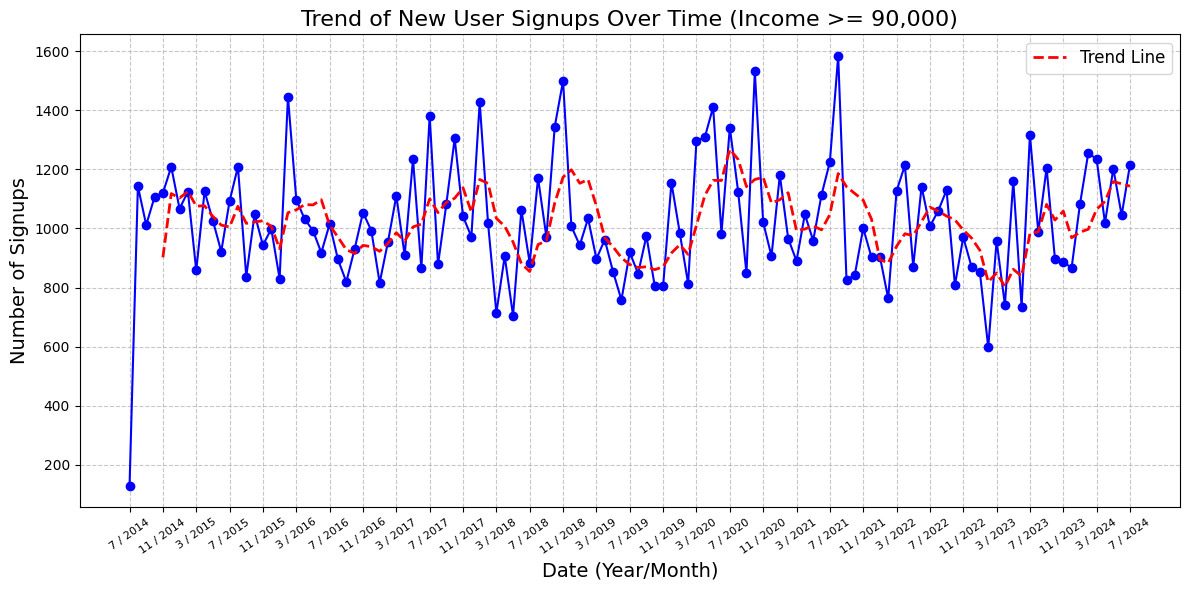

In [25]:
# Trend of user signups amongst users with income 90,000+

incomeGroup = data[data['annual_income'] >= 90000]
incomeGroup.drop(columns=['Unnamed: 0'], inplace=True)

incomeGroup['member_since_year'] = pd.DatetimeIndex(incomeGroup['member_since_date']).year
incomeGroup['member_since_month'] = pd.DatetimeIndex(incomeGroup['member_since_date']).month

incomeGroupByDate = incomeGroup[['user_id', 'member_since_year', 'member_since_month']].groupby(['member_since_year', 'member_since_month']).count().rename(columns={'user_id': 'numUsers'}).reset_index()

# Format dates into month-year
incomeGroupByDatePlot = incomeGroupByDate
incomeGroupByDatePlot['month_year'] = incomeGroupByDatePlot['member_since_month'].astype('str') + ' / ' + incomeGroupByDatePlot['member_since_year'].astype('str')

# Plot data
plt.figure(figsize=(12, 6))
plt.plot(incomeGroupByDatePlot['month_year'], incomeGroupByDatePlot['numUsers'], marker='o', linestyle='-', color='b')

# Customize the x-axis to show fewer ticks (sparse enough to be accessible)
plt.xticks(incomeGroupByDatePlot['month_year'][::4], fontsize=8, rotation=35)

# Customize other elements for clarity
plt.title('Trend of New User Signups Over Time (Income >= 90,000)', fontsize=16)
plt.xlabel('Date (Year/Month)', fontsize=14)
plt.ylabel('Number of Signups', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the trend with a smoother line (optional)
plt.plot(incomeGroupByDatePlot['month_year'], incomeGroupByDatePlot['numUsers'].rolling(window=5).mean(), color='red', linestyle='--', linewidth=2, label='Trend Line')
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
# Avg minutes run per Two Weeks - users with income 90,000+

runHoursTwoWeeksincome = incomeGroup
runHoursTwoWeeksincome['run_date'] = pd.to_datetime(runHoursTwoWeeksincome['run_date'])
runHoursTwoWeeksincome['month'] = runHoursTwoWeeksincome['run_date'].dt.month
runHoursTwoWeeksincome['year'] = runHoursTwoWeeksincome['run_date'].dt.year
runHoursTwoWeeksincome['isFirstHalf'] = runHoursTwoWeeksincome['run_date'].dt.day <= 15

runTwoWeekGroupIncome = runHoursTwoWeeksincome[['user_id', 'year', 'month', 'isFirstHalf', 'run_duration_min']].groupby(['user_id', 'year', 'month', 'isFirstHalf']).sum()[['run_duration_min']].rename(columns={'run_duration_min': 'minRunPerTwoWeeks'}).reset_index()
runTwoWeekGroupIncome.sort_values(by=['user_id', 'year', 'month', 'isFirstHalf'], ascending=[True, True, True, False])

annual_runTwoWeekMetricIncome = runTwoWeekGroupIncome[['year', 'minRunPerTwoWeeks']].groupby('year').mean().rename(columns={'minRunPerTwoWeeks': 'annAvgMinPerTwoWeeks'}).reset_index()
print(f"NTM: Annual Avg Min Run Per Two Weeks: \n{annual_runTwoWeekMetricIncome}")


NTM: Annual Avg Min Run Per Two Weeks: 
   year  annAvgMinPerTwoWeeks
0  2022             86.429128
1  2023             86.122136
2  2024             86.163136


In [27]:
# Number of users with activity logged 6 / 12 months in a year - users with income 90,000+
halfYearActiveIncome = incomeGroup
halfYearActiveIncome['run_date'] = pd.to_datetime(halfYearActiveIncome['run_date'])
halfYearActiveIncome['month'] = halfYearActiveIncome['run_date'].dt.month
halfYearActiveIncome['year'] = halfYearActiveIncome['run_date'].dt.year

# group by: user, year, month - then count
halfYearActiveIncome = halfYearActiveIncome[['user_id', 'year', 'month', 'run_date']].groupby(['user_id', 'year', 'month']).count().reset_index()
halfYearFinGroupIncome = halfYearActiveIncome.groupby(['user_id', 'year']).count().reset_index()[['user_id', 'year', 'run_date']].rename(columns={'run_date': 'monthsRunPerYear'})
halfYearFinGroupIncome.sort_values(by=['user_id', 'year'], ascending=[True, True])

halfYearTmp = {'year': [], 'pctRunHalfYear': []}
for y in [2022, 2023, 2024]:
    tmpYearGroup = halfYearFinGroupIncome[halfYearFinGroupIncome['year'] == y]
    halfYearTmp['year'].append(y)
    halfYearTmp['pctRunHalfYear'].append(len((tmpYearGroup[tmpYearGroup['monthsRunPerYear'] >= 6])) / len(tmpYearGroup))
halfYearResIncome = pd.DataFrame(halfYearTmp)
halfYearResIncome

,year,pctRunHalfYear
0,2022,0.655330
1,2023,0.656127
2,2024,0.192578


### Finding 7: 
##### The NSMs don't differentiate significantly from the average of all runners. There is a large uptick in user signups towards the end of 2023. This suggests annual income might have some discriminatory power and that the increase in popularity could be correlated with it. This would align with the idea that popular companies market their products to the upper-middle class. 